# ASAP 2.0 analyses with hyper-parameters

Purpose

    - Use hyperparameter search findings on ASAP 2.0 dataset 
    - Develop LLM scoring models for the ASAP 2.0 data using a Fine-tuned transformer based on hyperparameters.
    - This only uses the training and test set. No need for dev set because already tuned for hyperparameters.


## Dataset is ASAP 2.0.

https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data

But the dataset includes all the data.

~25,000 source-based essays

Scored from 1-6

Training and test sets defined

A variety of demographic information available including

  - economic disadvantage
  - disability (both gifted and challenged)
  - ELL
  - Race
  - Gender
  - Grade

## Install Packages

If you use the hugging_face environment, you will not need to install packages

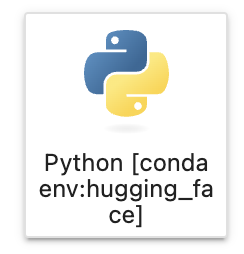

This was set up using this [link](https://github.com/learlab/development-server/wiki/Using-JupyterHub#virtual-environments-in-python)

In [1]:

#!pip install transformers[torch]
#!pip install --quiet transformers[torch] #datasets evaluate pingouin


## Import packages

In [2]:
#install transformers and other packages that might not exist
#!pip install transformers
#!pip install datasets
#!pip install evaluate
#!pip install transformers[sentencepiece]

In [3]:
#had some problems and needed to upgrade some stuff

#!pip install --upgrade pyarrow
#!pip uninstall -y datasets
#!pip install datasets

In [4]:
#!pip install scikit-learn


#import libraries that are not problematic

import pandas as pd # You know what this is
import sklearn
import numpy as np # Numpy is for whenever you have numbers in Python
import seaborn as sns # Plotting library based on MatPlotLib
from scipy import stats # Statistical distributions, functions, and a few tests
from IPython.display import display # print(), but for HTML output (like Pandas dataframes)

In [5]:
# The following packages and modules are all from HuggingFace

# A class for managing data with lots of useful features for model training
#!pip install --upgrade datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [7]:

# The following packages and modules are all from HuggingFace

# We import four classes from transformers.
from transformers import (
    # All language models start with tokens (by definition)
    AutoTokenizer,
    # Convenience class for creating and using transformer-based sequence classifiers
    AutoModelForSequenceClassification,
    # Configuration class for managing, you guessed it, training arguments
    TrainingArguments,
    # A class that abstracts away the PyTorch training loop.
    Trainer,
    # A data collator organizes (collates) the data into batches for training
    # It will also add special [PAD] tokens to make all the sequences in a batch the same length
    # Batches with equal-length sequences make our GPU go brr
    DataCollatorWithPadding,
    DefaultDataCollator
)

# A library for performance evaluations metrics
# Especially useful for complex and task-specific metrics
# For example, the GLUE metric can score language models on a suite of popular benchmarks
# But we will just use some simple metrics today
# import evaluate

# Pipelines are used to streamline tokenization and inference
# We will create a pipeline after finetuning!
from transformers import pipeline


# Load the tokenizer to combine prompt and text
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)



## Load and Prepare ASAP Corpus

In [10]:
asap_df = (
    pd.read_csv("./data/ASAP2_competitiondf_with-metadata.csv"))

asap_df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task
0,AAAVUP14319000159574,4,The author suggests that studying Venus is wor...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,Black/African American,F,10.0,409.0,PERSUADE,Text dependent
1,AAAVUP14319000159542,2,NASA is fighting to be alble to to go to Venus...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,10.0,197.0,PERSUADE,Text dependent
2,AAAVUP14319000159461,3,"""The Evening Star"", is one of the brightest po...",test,private,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,White,M,10.0,361.0,MI,Text dependent
3,AAAVUP14319000159420,2,The author supports this idea because from rea...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,F,10.0,209.0,MI,Text dependent
4,AAAVUP14319000159419,2,How the author supports this idea is that he s...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,M,10.0,214.0,MI,Text dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24723,5022045,3,Everyone should have an opinion on what they t...,train,0,Write a letter to your state senator in which ...,Does the electoral college work?,NaN,NaN,No,Asian/Pacific Islander,M,9.0,355.0,PERSUADE,Text dependent
24724,5022027,4,The debate on the pros and cons of car usage h...,train,0,Write an explanatory essay to inform fellow ci...,Car-free cities,NaN,NaN,No,Hispanic/Latino,F,10.0,303.0,PERSUADE,Text dependent
24725,5022023,1,dear senator:\n\nthe electoral college most be...,train,0,Write a letter to your state senator in which ...,Does the electoral college work?,NaN,NaN,Yes,Hispanic/Latino,F,9.0,256.0,PERSUADE,Text dependent
24726,5022018,2,"New cars are invented almost everyday, some ar...",train,0,Write an explanatory essay to inform fellow ci...,Car-free cities,NaN,NaN,No,Hispanic/Latino,F,10.0,253.0,PERSUADE,Text dependent


### Basic descriptives

In [11]:
print(asap_df.shape)

print(asap_df['pubpriv'].unique())
print(asap_df['pubpriv'].value_counts())

(24728, 16)
['0' 'private' 'public']
pubpriv
0          17307
private     5164
public      2257
Name: count, dtype: int64


In [12]:
#number of words

mean_nw = asap_df['essay_word_count'].mean()
sd_nw = asap_df['essay_word_count'].std()
max_nw = asap_df['essay_word_count'].max()

print(f'mean number of words = {mean_nw}')
print(f'sd for number of words = {sd_nw}')
print(f'max for number of words = {max_nw}')


#how many essays are greated than 512 words? (almost 4k)

llm_max = 512

llm_over = (asap_df['essay_word_count'] > llm_max).sum()
print(f'essays that are over 512 word = {llm_over}')


mean number of words = 366.0652631578947
sd for number of words = 217.15314119783275
max for number of words = 8944.0
essays that are over 512 word = 3638


In [13]:
#statistics on the data itself

prompt_count = asap_df['prompt_name'].value_counts()
ed_count = asap_df['economically_disadvantaged'].value_counts()
sd_count = asap_df['student_disability_status'].value_counts()
ell_count = asap_df['ell_status'].value_counts()
re_count = asap_df['race_ethnicity'].value_counts()
gen_count = asap_df['gender'].value_counts()
grade_count = asap_df['grade_level'].value_counts()

print(prompt_count)
print("\n")
print(ed_count)
print("\n")
print(sd_count)
print("\n")
print(ell_count)
print("\n")
print(re_count)
print("\n")
print(gen_count)
print("\n")
print(grade_count)

prompt_name
Driverless cars                     6166
Facial action coding system         4877
Exploring Venus                     4476
The Face on Mars                    3005
"A Cowboy Who Rode the Waves"       2175
Does the electoral college work?    2046
Car-free cities                     1955
Name: count, dtype: int64


economically_disadvantaged
Economically disadvantaged        12766
Not economically disadvantaged     7933
Name: count, dtype: int64


student_disability_status
Not identified as having disability    17724
Identified as having disability         2975
Name: count, dtype: int64


ell_status
No     20991
Yes     3267
Name: count, dtype: int64


race_ethnicity
White                             9841
Hispanic/Latino                   7181
Black/African American            4588
Two or more races/Other           1525
Asian/Pacific Islander            1417
American Indian/Alaskan Native     144
Name: count, dtype: int64


gender
M    12498
F    12202
Name: count, dtype: int

In [27]:
#get columns you want and rename them using correct conventions
asap_df
asap_df['text'] = asap_df.apply(lambda row: row['full_text'] + tokenizer.sep_token + str(row['assignment']), axis=1)
asap_df2 = asap_df[['text', 'score', 'pubpriv']].rename(columns={'score': 'label'})


'-Introduction-\n\nSo in the article,"The Challenge of Exploring Venus", the author goes through explanations why studying the planet Venus is worth the time. He begins to go through many details on why we should study the planet Venus despite it\'s the danger it can present. Now i\'m going to discuss why the author suggests studying Venus despite all the dangers it can bring.\n\nThe author mentions that Venus is often reffered to as Earth\'s "twin" due to haveing very similar simularities. According to the article, "Venus is the closest planet to Earth in terms of density and size".(para.2). The author then explains some of the reasons why Venus is very dangerous to land on for man. According to the article, "Venus has the hottest surface temerature of any planet in our solar system"(para.3).\n\nSome of the other reasons that make Venus a very dangerous planet\n\nis it\'s thick atmosphere. According to the article, "A thick atmosphere pf almost 97 percent carbon dioxide blankets Venus

In [10]:
print(asap_df2.dtypes)

#label is a int64, but it needs to be float64 for the transformer to work

asap_df2['label'] = asap_df2['label'].astype('float64')

print(asap_df2.dtypes)

text       object
label       int64
pubpriv    object
dtype: object
text        object
label      float64
pubpriv     object
dtype: object


### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [11]:
# Don't use entirety of "test" - just use the private "test"
# For training, only use "train" for training; don't use public "test" because it was used for hyperparamter tuning

asap_dd = datasets.DatasetDict({
   "train": datasets.Dataset.from_pandas(asap_df2[asap_df2["pubpriv"] == "0"]),
   "test": datasets.Dataset.from_pandas(asap_df2[asap_df2["pubpriv"] == "private"])
})

In [12]:
#! View the structure of the train set
#! display() the first (0th) example

display(asap_dd["train"]) #features
display(asap_dd["test"]) #features
display(asap_dd["train"][0]) #text

Dataset({
    features: ['text', 'label', 'pubpriv', '__index_level_0__'],
    num_rows: 17307
})

Dataset({
    features: ['text', 'label', 'pubpriv', '__index_level_0__'],
    num_rows: 5164
})

{'text': 'The author suggests that studying Venus is worthy enough even though it is very dangerous. The author mentioned that on the planet\'s surface, temperatures average over 800 degrees Fahrenheit, and the atmospheric pressure is 90 times greater than what we experience on our own planet . His solution to survive this weather that is dangerous to us humans is to allow them to float above the fray. A "blimp-like" vehicle hovering 30 or so miles would help avoid the unfriendly ground conditions . At thirty-plus miles above the surface, temperatures would still be toasty at around 170 degrees Fahrenheit, but the air pressure would be close to that of sea level on Earth. So not easy conditions, but survivable enough for humans. So this would help make the mission capeable of completing.\n\nHe also mentions how peering at venus from a ship orbiting or hovering safely far above the planet can provide only limited insight on ground conditions because most forms of light cannot penertrate

In [19]:
#! Find the lowest scored essay in the training set.

# Loop
min_writing = 1 #change this number to see various scores
for sample in asap_dd["train"]:
  if sample["label"] == min_writing:
    min_writing = sample["label"]
    min_sample = sample
display(min_sample)


{'text': 'dear senator:\n\nthe electoral college most be important that makes the people to chose what do they want it consists to make the people take their own desiton about who do they want to help them and make their lives better in al the ways, the electors have to be near the people of the town or city cause in that way the people feels more closer to them and they can trust the work of the electors.\n\nthe certificate of ascertainment declares that the winnig presidential elector in the state ans whows which elector will be represent the state at the meeting of the electors in december of the election year,that means that you help choose your state\'s electors when you vote for a president because when you voete for you candidate you are actually voting for your candidate\'s electors.\n\nafter a presidential election , the governor prepares a "certificates" of ascertainment"\n\nyour state are sent to the congress and the national archives as part of the official records of the p

In [9]:
# Training regression-type models requires a floating point response variable
# The Type is "Value", which comes from the datasets library
asap_dd["train"].features['label']

Value(dtype='float64', id=None)

### Pre-process inputs (tokenization)

This is for train, dev, and test sets as set up.

`transformers` will handle tokenization, but it's worth looking at what it does.  Huggingface toenization course [here](https://huggingface.co/course/chapter2/4?fw=pt).

Different models require different types of tokenization. You need to choose a model before you tokenize. 

This will use [roberta-large](https://huggingface.co/microsoft/deberta-v3-large) from huggingface. 

Want to run deberta-v3-large, but having problems (microsoft/deberta-v3-large)

In [13]:
# Instantiate tokenizer by downloading tokenizer config files from HF Hub
#tokenizer = AutoTokenizer.from_pretrained('roberta-large') #roberta works
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large') #deberta requires transformers[sentencepiece] or 
#tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False) 
#transformers now uses fast tokenizers by default, but the deberta tokenizer is a slow tokenizer
tokenizer.name_or_path #what tokenizer are we using?

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


'microsoft/deberta-v3-large'

In [14]:
# Define tokenizing function
# Models usually have a max length (the number of tokens they can process per sample)
# roberta-large max length is 512 tokens, which is about 300-400 words.
# Many essays will be longer (around 4K)

def tokenize_inputs(example):
    # This will automatically truncate documents over 512 tokens
    # Truncation is a limitation.
    # If you truncate, clearly describe how many texts are truncated, by how much.
    #max_length=512 cuts essays to 512 words
    return tokenizer(example['text'], truncation=True, max_length=512)

In [15]:
# Do the tokenizing using DataDict.map()
# We remove "text" because it is not used by the transformer.
# Transformers operate on token_ids
asap_dd_tokenized = asap_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map: 100%|██████████| 5164/5164 [00:01<00:00, 2734.18 examples/s]


In [13]:
#what's in the data

asap_dd_tokenized

DatasetDict({
    train: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17307
    })
    test: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5164
    })
})

After tokenization, text samples are transformed as follows:

The **text** field is replaced with two new fields:

*   **input_ids**

The `input_ids` field contains the tokenized input sequences represented as token IDs.

*   **attention_mask**

The `attention_mask` field contains attention masks, which indicate which tokens should be attended to and which should be ignored during model training. In this case, the attention mask is all 1s, indicating that every token is attended to.

In [25]:
#! Grab the 0th item in the train portion of our tokenized dataset and iterate over its .items()
#! print() key and value from inside this loop to see what the tokenized inputs look like.

for key, value in asap_dd_tokenized["train"][0].items():
  print(key, value)

label 4.0
pubpriv 0
__index_level_0__ 0
input_ids [1, 279, 1806, 3660, 272, 4367, 14962, 269, 6786, 618, 402, 651, 278, 269, 379, 3051, 260, 279, 1806, 1979, 272, 277, 262, 3568, 280, 268, 1694, 261, 4743, 1210, 360, 5114, 3203, 25415, 261, 263, 262, 13123, 1517, 269, 2156, 631, 1761, 354, 339, 301, 517, 277, 316, 451, 3568, 323, 855, 1327, 264, 4601, 291, 1742, 272, 269, 3051, 264, 381, 3691, 269, 264, 1052, 349, 264, 10903, 764, 262, 34368, 260, 336, 307, 1285, 79068, 271, 2207, 309, 1508, 24931, 703, 289, 324, 1747, 338, 408, 1662, 262, 53486, 1353, 1232, 323, 620, 6302, 271, 8990, 1747, 764, 262, 1694, 261, 4743, 338, 449, 282, 47940, 288, 441, 11881, 3203, 25415, 261, 304, 262, 925, 1517, 338, 282, 828, 264, 272, 265, 2164, 674, 277, 2610, 260, 471, 298, 639, 1232, 261, 304, 12271, 52391, 1950, 618, 270, 3691, 260, 471, 291, 338, 408, 365, 262, 2151, 21146, 1950, 265, 5817, 260, 383, 327, 12583, 361, 44282, 288, 116896, 292, 266, 2539, 42758, 289, 24931, 5044, 659, 764, 262, 3568,

In [14]:
#what is the max length of the input ids (i.e., did they truncate)

max_length = max([len(n['input_ids']) for n in asap_dd_tokenized['train']] +
                 [len(n['input_ids']) for n in asap_dd_tokenized['test']])

print(max_length)

512


### Data Collator
A data collator feeds the data to the language model. There are some interesting optimizations that can be made [here](https://huggingface.co/course/chapter3/2?fw=pt).




In [19]:
# Instantiate data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#This data collator is used to dynamically pad input sequences to the maximum length within each batch during training
#ensures that all sequences within a batch have the same length by adding padding tokens to the shorter sequences
#DataCollatorWithPadding handles variable-length input sequences and avoids the need for manual padding or truncation


## USE HYPERPARAMETER TUNING

**it is only based on a training and test set**

Hyperparameter tuning was done in 

active-projects/asap_scoring/asap_llm_hyper_search_final.ipynb

The results are below.

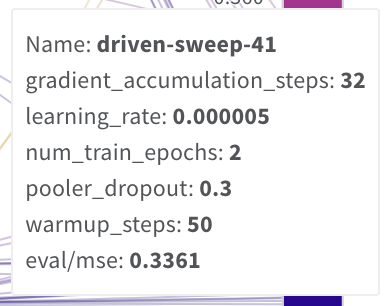


## Set up Training



### Define model and task


### `AutoModelForSequenceClassification.from_pretrained()`

1.   Downloads the model you specify from the HuggingFace Hub. Downloading a model means downloading the pretrained model weights, as well as some configuration files. The model architecture is already described inside the `transformers` library.
2.   Discards the language modeling head of the model.
3.   Creates a brand new sequence classification head with randomly initialized weights -- you will see some warnings about this to remind you that you need to train the model!

### `model_init`
We use a `model_init()` function here instead of loading the model directly. This way, we will get a fresh distilbert everytime we rerun later code cells. This allows us to start training from the Huggingface checkpoint on every training run. In other words, we guarantee that training will always start from the Hugginface weights. This prevents us from accidentally resuming training when we don't mean to!


In [20]:
# Define a model init function, which will help us start training from scratch
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(
      'microsoft/deberta-v3-large',
      #'roberta-large', # the name of the model on HuggingFace Hub
      num_labels=1, # Regression is just classification with a single, continous label. So intuitive!
      pooler_dropout=0.3, 
      # Add pooler dropout, which applies dropout to the pooling layer to help prevent overfitting by randomly dropping out units during training.
      # This is from hyperparameter tuning    
      )

### Define Metrics

Let's consider what metrics might be useful for training this model. Lots of metrics are available to us through [HF Datasets Metrics repo](https://huggingface.co/metrics).

In [21]:
# Load some useful performance metrics using evaluate library
# These metrics are complementary. They tell us different things about model performance.
metrics = evaluate.combine(
    #combine multiple evaluation metrics into a single evaluation object 
    {
        # Root Mean Squared Error (RMSE); lower is better; more sensitive to few big errors
        "RMSE" : evaluate.load("mse", squared=False),
        # Mean Absolute Error; lower is better; less sensitive to few big errors
        "MAE": evaluate.load('mae')
    }
)

# Define compute_metrics()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Alternative option is to use sklearn metrics here
    return metrics.compute(predictions=logits, references=labels) #logits refer to the raw, unnormalized outputs of the final layer of model
                                                                  #labels are the true values being predicted.

In [22]:
for metric in metrics.evaluation_modules:
  print(f"{metric.name:_^80}") #spacer
  print(metric.description) #description of metric if curious

______________________________________mse_______________________________________
Mean Squared Error(MSE) is the average of the square of difference between the predicted
and actual values.

______________________________________mae_______________________________________
Mean Absolute Error (MAE) is the mean of the magnitude of difference between the predicted and actual
values.



### Model Training


In [23]:
#will need to know where to store output
import os

current_directory = os.getcwd()
print(current_directory)


/home/jovyan/active-projects/asap_scoring


In [24]:

training_args = TrainingArguments(
    # directory to save model checkpoints
    output_dir="/home/jovyan/active-projects/asap_scoring/hyper_parameter_model",
    # how often to log. 'epoch' means that logging will happen at the end of every epoch
    logging_strategy='epoch',
    # how often to evaluate performance
    eval_strategy='epoch',
    # how often to save a model checkpoint
    save_strategy='no',
    # If an earlier checkpoint was better than the last one, load that checkpoint from disk
    # We cannot do this, because we don't have a development set
    load_best_model_at_end=False,
    # Not used; how to choose which model was best
    metric_for_best_model=None,
    # Not used; but lower RMSE is better
    greater_is_better=False,
    per_device_train_batch_size= 2, # 8 or 16 are typical. Switch to 2 to avoid OutOfMemoryError!
    per_device_eval_batch_size= 2, # 8 or 16 are typical. Switch to 2 to avoid OutOfMemoryError!
    #! Try 1e-5, 5e-5, or 1e-4.
    learning_rate= 0.000005,
    #! Try 2, 3, or 4 epochs
    num_train_epochs=2,# Add gradient accumulation steps
    #add gradient accumulation which helps to stabilize the training by effectively increasing the batch size
    gradient_accumulation_steps=32,
    # Add warmup steps, which gradually increase the learning rate to  stabilize training during the initial steps.
    warmup_steps=50,
    report_to= "none", #this should stop wandb from firing, which saves a lot of heartache
)

In [25]:

# We defined all these components in the code above and saved them as variables
# Add those variables as arguments to the Trainer call to make our trainer :)
trainer = Trainer(
    # notice that this is "model_init" and NOT "model_init()"
    # if we add the (), it will evaluate the function and provide the func output to the trainer
    # but we want to give the function itself to the trainer
    # functions are just objects, and we can pass them around by name
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    train_dataset=asap_dd_tokenized["train"], #! the training dataset
    eval_dataset=asap_dd_tokenized["test"], #! the testing set 
    compute_metrics=compute_metrics,
)



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Finetune the model
finetune the model!


In [26]:


trainer.train()

trainer.save_model(
    output_dir="/home/jovyan/active-projects/asap_scoring/hyper_parameter_model"
)
#this will save the model trained on the training data. We can use that later to test the training model on the test set.

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
0,1.564900,0.388089,0.388089,0.485510
1,0.391100,0.359971,0.359971,0.464795


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Results from Hyperparameter model**


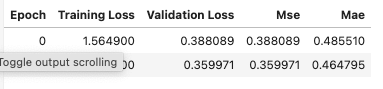


**Comparison Results**

These are the results from the model not tuned based on hyper-parameter tuning.

*Results from the train/validation run without Hyper-parameter search*

TrainOutput(global_step=3246, training_loss=0.34734542856081285, metrics={'train_runtime': 6000.1827, 'train_samples_per_second': 8.653, 'train_steps_per_second': 0.541, 'total_flos': 4.836970157388125e+16, 'train_loss': 0.34734542856081285, 'epoch': 3.0})

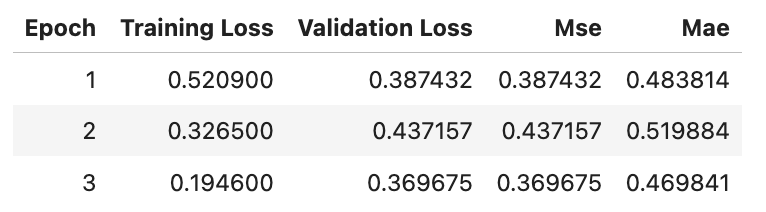

*Results from the running the train/validation model above on the test set*

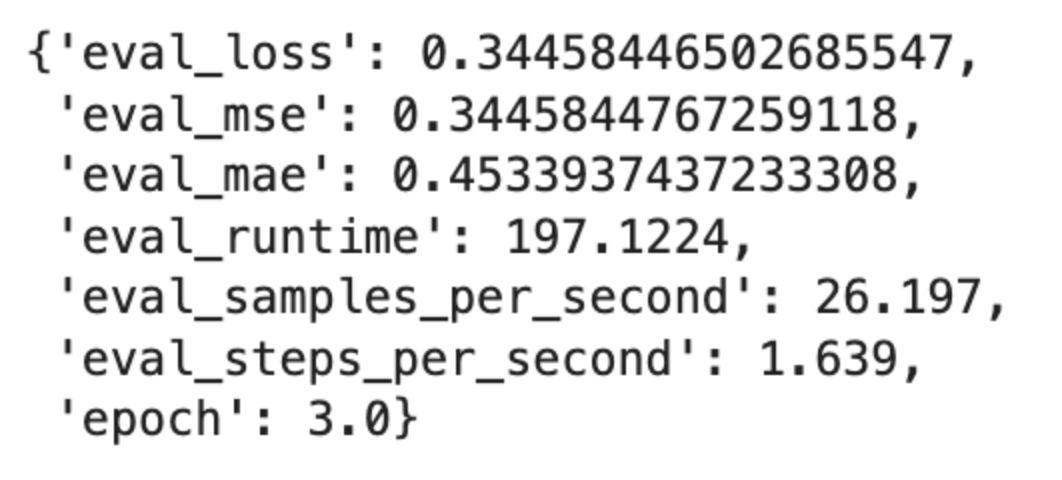

In [27]:
#evaluates on test set
trainer.evaluate(
    asap_dd_tokenized["test"]
    )

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.3599712550640106,
 'eval_mse': 0.35997127510555743,
 'eval_mae': 0.46479457808408875,
 'eval_runtime': 195.7985,
 'eval_samples_per_second': 26.374,
 'eval_steps_per_second': 13.187,
 'epoch': 1.9967645019644094}

{'eval_loss': 0.3599712550640106,
 'eval_mse': 0.35997127510555743,
 'eval_mae': 0.46479457808408875,
 'eval_runtime': 195.7985,
 'eval_samples_per_second': 26.374,
 'eval_steps_per_second': 13.187,
 'epoch': 1.9967645019644094}

 Here's what each of these components is telling us:

epoch: the epoch number at which the evaluation is performed.

eval_loss: the evaluation loss. The evaluation loss is a measure of how well the model performs on the evaluation dataset, with lower values indicating better performance.

eval_mse: Why is this the same as eval_loss? Because mean-squared error was our loss function!

eval_mae: Mean Absolute Error

eval_runtime: the total runtime of the evaluation process in seconds.

eval_samples_per_second: the number of samples processed per second.

eval_steps_per_second: the number of batches processed per second.

In [28]:
#Generate predictions using the trained model on a given datase

pred = trainer.predict(
    asap_dd_tokenized["test"]
)

print(pred.predictions)#the predicitions
print(pred.metrics)#the metrics

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[1.9069762 4.2317324 2.5674455 ... 2.4829235 3.4350843 2.231167 ]
{'test_loss': 0.3599712550640106, 'test_mse': 0.35997127510555743, 'test_mae': 0.46479457808408875, 'test_runtime': 197.4437, 'test_samples_per_second': 26.154, 'test_steps_per_second': 13.077}


Results for metrics

[1.9069762 4.2317324 2.5674455 ... 2.4829235 3.4350843 2.231167 ]
{'test_loss': 0.3599712550640106, 'test_mse': 0.35997127510555743, 'test_mae': 0.46479457808408875, 'test_runtime': 197.4437, 'test_samples_per_second': 26.154, 'test_steps_per_second': 13.077}

In [29]:
# .reshape(-1) removes an empty dimension
# We get a one-dimensional array (similar to a list)
pred.predictions.reshape(-1)

array([1.9069762, 4.2317324, 2.5674455, ..., 2.4829235, 3.4350843,
       2.231167 ], dtype=float32)

In [30]:
# Create a dataframe for inspection
preds_df = pd.DataFrame(
    {
        'predicted':pred.predictions.reshape(-1), # flatten array
        'true':pred.label_ids,
        'text':asap_dd['test']['text'] #! Add the text column of the test partition here
    }
)
display(preds_df.sample(2)) # .sample(2) randomly selects 2 rows

,predicted,true,text
1726,3.195048,3.0,Technology is becoming more advanced everyday....
1666,2.306140,2.0,If technology in classrooms read students emot...


In [31]:
preds_df.shape

(5164, 3)

In [32]:
#save dataframe for later use

preds_df.to_csv('hyper_parameterized_test_results_asap.csv', index=False)

R-squared: 0.690, P-value= 0.000


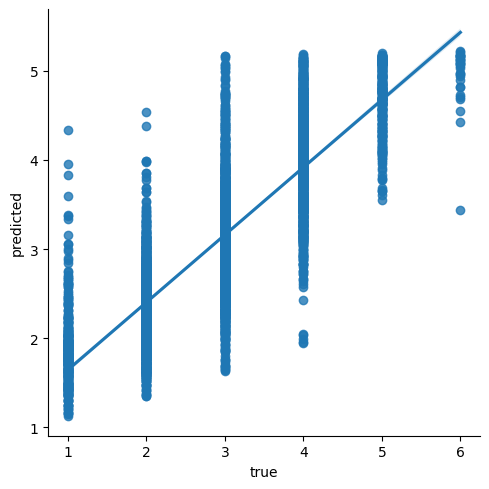

In [33]:
# Run the simple linear regression
results = stats.linregress(preds_df["true"], preds_df["predicted"])

# Using an f-string to clearly display and round the relevant output
print(f"R-squared: {results.rvalue**2:.3f}, P-value= {results.pvalue:.3f}")

# Plot the data with a regression line
sns.lmplot(x='true', y='predicted', data=preds_df);

This is COMPARISON to train/test without hyper-parameter tuning

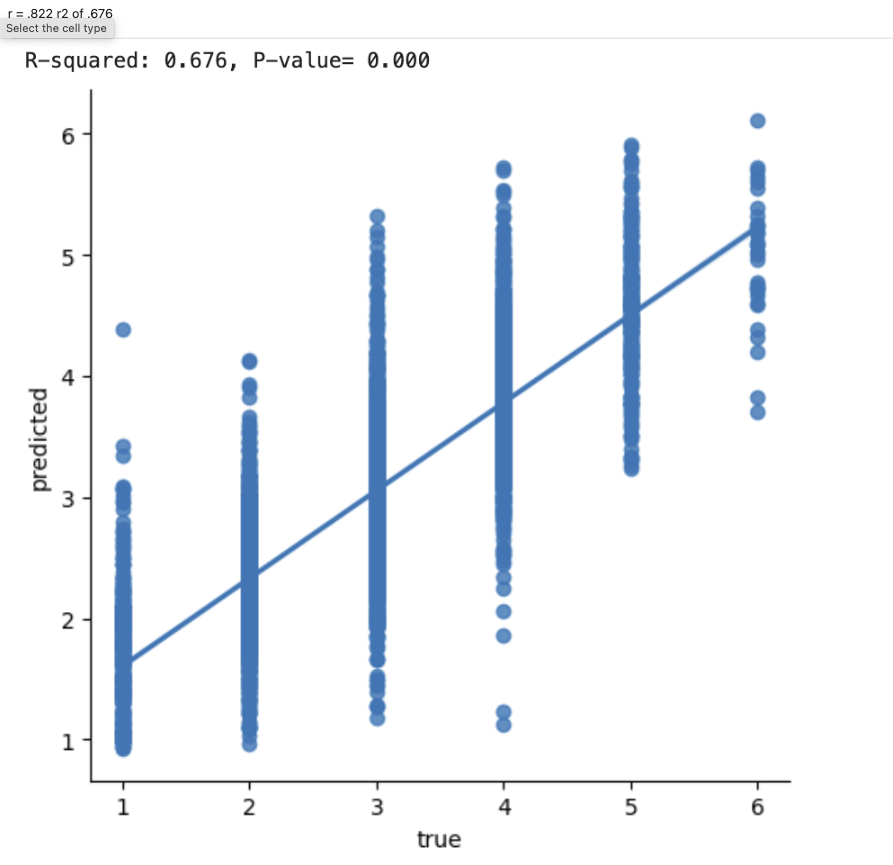

### Calling in saved model

This is the easiest solution if you return to this notebook long after it has been run.

It will allow you to retrieve saved model as needed without retraining the model using all the steps above




In [5]:
#call in the saved model

#The chunk above saved three items
# 1. Config.json: Configuration settings for transformer model like the model architecture
# 2. model.safetensors: weights and parameters of the trained transformer model
# 3. training_args.bin: the arguments and settings that were used during the training process of the transformer model
# learning rate, batch size, etc...

# call in a new variable called trainer_saved and use it below for trainer_saved.evaluate and trainer_saved.predict

#set path
PATH = "/home/jovyan/active-projects/asap_scoring/hyper_parameter_model"

num_labels = 1 #for regression analysis. This would change with classification
model = AutoModelForSequenceClassification.from_pretrained(PATH, num_labels=num_labels)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element